In [31]:
import os
import glob
import time

import numpy as np
import cv2
import pickle
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('..')
from mvt.trackerlib import normalize_vectors

import torchvision
from torchvision import datasets, models, transforms

### Load data

In [34]:
frames = []
frame_types = []
det_boxes = []
gt_boxes = []
gt_ids = []
motion_vectors = []
motion_vector_subsets = []
box_ids = []

dev_outputs = sorted(glob.glob("../dev_output/*.pkl"))
for frame_idx, dev_output in enumerate(dev_outputs):
    data = pickle.load(open(dev_output, "rb"))

    frame = data["frame"]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_type = data["frame_type"]
    det_box = data["det_boxes"]
    gt_box = data["gt_boxes"]
    gt_id = data["gt_ids"]
    motion_vector = data["motion_vectors"]
    tracker_debug_data = data["tracker_debug_data"]
    
    frames.append(frame)
    frame_types.append(frame_type)
    det_boxes.append(det_box)
    gt_boxes.append(gt_box)
    gt_ids.append(gt_id)
    motion_vectors.append(motion_vector)
    
    box_ids.append(tracker_debug_data["box_ids"])
    
    if tracker_debug_data["type"] == "predict":
        motion_vector_subsets.append(tracker_debug_data["motion_vector_subsets"])
    else:
        motion_vector_subsets.append(None)

In [35]:
for frame_idx in range(len(motion_vectors)):
    motion_vectors[frame_idx] = normalize_vectors(motion_vectors[frame_idx])

### Data Preprocessing

#### Interpolate motion vectors on 2D grid with fixed 16 x 16 spacing

In [36]:
from scipy.interpolate import griddata


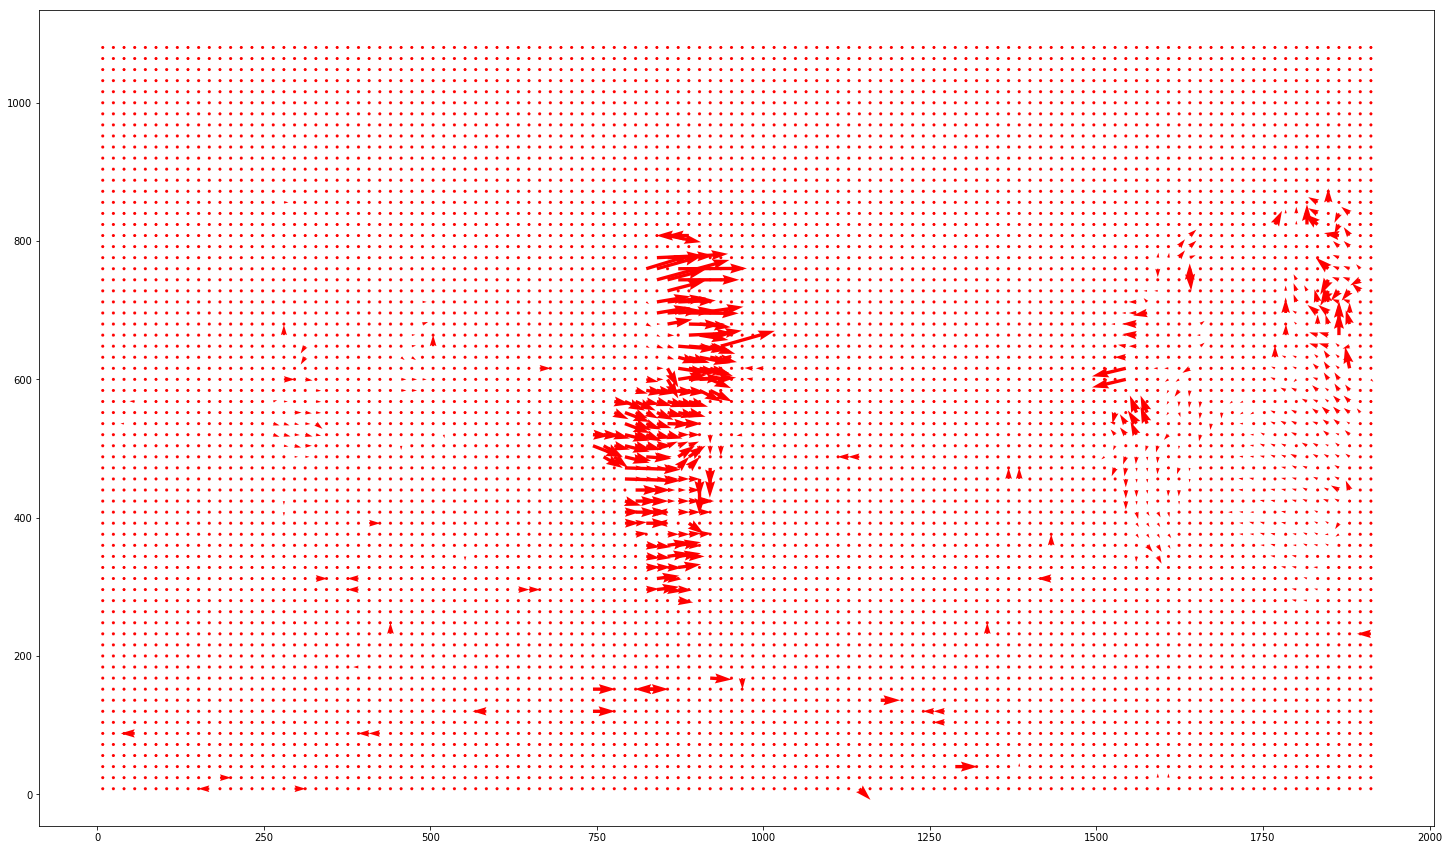

In [37]:
frame_idx = 73
mvs_x = motion_vectors[frame_idx][:, 5]
mvs_y = motion_vectors[frame_idx][:, 6]
mvs_x_motion = motion_vectors[frame_idx][:, 7] / motion_vectors[frame_idx][:, 9]
mvs_y_motion = motion_vectors[frame_idx][:, 8] / motion_vectors[frame_idx][:, 9]

# takes 5.72 ms (average of 1000 runs)
xi = np.arange(8, 1920+1, 16)
yi = np.arange(8, 1080+1, 16)
mvs_x_motion_interp = griddata((mvs_x, mvs_y), mvs_x_motion, (xi[None, :], yi[:, None]), method='nearest')
mvs_y_motion_interp = griddata((mvs_x, mvs_y), mvs_y_motion, (xi[None, :], yi[:, None]), method='nearest')
    
f, ax = plt.subplots(figsize=(25,15))
#ax.quiver(mvs_x, mvs_y, mvs_x_motion, mvs_y_motion, scale=1000)
ax.quiver(xi, yi, mvs_x_motion_interp, mvs_y_motion_interp, scale=1000, color='r')

### Create Pytorch Datatset

In [38]:
x = []
y = []
for frame_idx in range(1, len(gt_boxes)): # first velocity can not be computed so skip it
    
    if motion_vectors[frame_idx].size:  # for non-keyframe
        
        # motion vectors (interpolated on grid)
        mvs_x_motion_interp, mvs_y_motion_interp = interp_motion_vectors(motion_vectors[frame_idx])
        mvs_interp = torch.from_numpy(np.dstack((mvs_x_motion_interp, mvs_y_motion_interp)))
        x.append(mvs_interp)
        
        # box velocities
        # find matching boxes which occur in both frames
        _, idx_1, idx_0 = np.intersect1d(gt_ids[frame_idx], gt_ids[frame_idx-1], assume_unique=True, return_indices=True)
        # compute the box velocities
        velocities = gt_boxes[frame_idx][idx_1] - gt_boxes[frame_idx-1][idx_0]
        y.append(torch.from_numpy(velocities))
        
    else:
        print(f"Skipping frame {frame_idx}")

Skipping frame 250
Skipping frame 500


In [ ]:
frame_idx = 73
f, ax = plt.subplots(figsize=(25,15))
x = motion_vectors[frame_idx][:, 5]
y = motion_vectors[frame_idx][:, 6]
u = motion_vectors[frame_idx][:, 7] / motion_vectors[frame_idx][:, 9]
v = motion_vectors[frame_idx][:, 8] / motion_vectors[frame_idx][:, 9]
ax.quiver(x, y, u, v, scale=1000)

x = motion_vectors[frame_idx+1][:, 5]
y = motion_vectors[frame_idx+1][:, 6]
u = motion_vectors[frame_idx+1][:, 7] / motion_vectors[frame_idx+1][:, 9]
v = motion_vectors[frame_idx+1][:, 8] / motion_vectors[frame_idx+1][:, 9]
ax.quiver(x, y, u, v, scale=1000, color='r')

x = motion_vectors[frame_idx+2][:, 5]
y = motion_vectors[frame_idx+2][:, 6]
u = motion_vectors[frame_idx+2][:, 7] / motion_vectors[frame_idx+2][:, 9]
v = motion_vectors[frame_idx+2][:, 8] / motion_vectors[frame_idx+2][:, 9]
ax.quiver(x, y, u, v, scale=1000, color='b')

### Equalize numbers of motion_vectors throughout frames

In [210]:
def vector_matching_ratio(a, b):
    1 - (np.linalg.norm((a - b), axis=1)) / ()
    return 

vmr = vector_matching_ratio(motion_vectors[frame_idx][:, 7:9], motion_vectors[frame_idx-1][:, 7:9])

In [221]:
frame_idx = 74
len(np.linalg.norm((motion_vectors[frame_idx][:, 7:9] - motion_vectors[frame_idx-1][:, 7:9]), axis=1))

ValueError: operands could not be broadcast together with shapes (7829,2) (7875,2) 

In [104]:
pt = 8000
motion_vectors[frame_idx][pt:pt+100, :]

array([[ -1,  16,  16, 216, 600, 216, 600,   0,   0,   4],
       [ -1,  16,  16, 232, 600, 232, 600,   0,   0,   4],
       [ -1,  16,  16, 232, 600, 232, 600,   0,   0,   4],
       [ -1,  16,  16, 248, 600, 248, 600,   0,   0,   4],
       [ -1,  16,  16, 248, 600, 248, 600,   0,   0,   4],
       [ -1,  16,  16, 264, 600, 264, 600,   0,   0,   4],
       [ -1,  16,  16, 264, 600, 264, 600,   0,   0,   4],
       [ -1,  16,  16, 287, 600, 280, 600,  31,   0,   4],
       [ -1,  16,  16, 295, 600, 296, 600,   4,  -3,   4],
       [ -1,  16,  16, 296, 600, 296, 600,   0,  -3,   4],
       [ -1,  16,  16, 317, 600, 312, 600,  21,  -3,   4],
       [ -1,  16,  16, 328, 600, 328, 600,   0,   0,   4],
       [ -1,  16,  16, 344, 600, 344, 600,   0,   0,   4],
       [ -1,  16,  16, 360, 600, 360, 600,   0,   0,   4],
       [ -1,  16,  16, 360, 600, 360, 600,   0,   0,   4],
       [ -1,  16,  16, 376, 600, 376, 600,   0,   0,   4],
       [ -1,  16,  16, 376, 600, 376, 600,   0,   0,   4

In [154]:
frame_idx = 73

motion_vectors[frame_idx] = get_nonzero_vectors(motion_vectors[frame_idx])

mv = motion_vectors[frame_idx][:, 7:9]

In [155]:
mv

array([[ -1,  -1],
       [ -1,  -1],
       [-32,   0],
       ...,
       [  1,   0],
       [  0,   1],
       [ -1,   0]], dtype=int32)